In [50]:
import os
import warnings

import pandas as pd
import numpy as np
import weighted

from tqdm import tqdm

from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
    get_derived_csv_path,
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [2]:
def transaction_period_to_date(transaction_period):
    """
    4th quarter 2020 -> (4, 2020)
    """
    split = transaction_period.split(" ")
    return int(split[0][0]), int(split[2])


def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [3]:
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in os.listdir(trade_prices_data_path)
]

In [4]:
req_int_columns = ["Transaction-price(total)", "Area(m^2)"]

req_float_columns = ["Transaction-price(Unit price m^2)"]

req_object_columns = [
    "City,Town,Ward,Village code",
    "Type",
    "Transaction period",
]

required_columns = req_int_columns + req_float_columns + req_object_columns

float_filler = dict((col, 0) for col in req_float_columns)
int_filler = dict((col, 0) for col in req_int_columns)
object_filler = dict((col, "na") for col in req_object_columns)
na_filler = {**float_filler, **int_filler, **object_filler}

In [5]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city["1101"]}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area["1100"]}") 

# In the future, we may want to use the 175 sub cities and just skip this
# Problem currently is that we don't have taxable income for sub cities
def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [59]:
def custom_aggregate(x):
    d = {}
    d["unit_price_wmean"] = np.average(x["unit_price"], weights=x["trade_area"])
    d["unit_price_wmedian"] = weighted.median(x["unit_price"], weights=x["trade_area"])
    d["unit_price_mean"] = x["unit_price"].mean()
    d["unit_price_median"] = x["unit_price"].median()
    d["total_traded_area"] = x["trade_area"].sum()
    d["count"] = x["count"].count()
    return pd.Series(
        d,
        index=[
            "unit_price_wmean",
            "unit_price_wmedian",
            "unit_price_mean",
            "unit_price_median",
            "total_traded_area",
            "count",
        ],
    )

In [60]:
derived_dfs = {
    "land": pd.DataFrame(),
    "building": pd.DataFrame()
}

pbar = tqdm(total=len(trade_prices_data_paths))

for path in trade_prices_data_paths:
    main_df = pd.read_csv(path, usecols=required_columns, encoding="unicode_escape")
    main_df = main_df.assign(count=1)

    main_df["area_code"] = main_df["City,Town,Ward,Village code"].astype(str)

    # we may want to skip the following step in the future
    main_df["area_code"] = main_df["area_code"].apply(get_city_code)
    main_df["area"] = main_df["area_code"].apply(get_area_from_area_code)

    main_df["trade_price"] = main_df["Transaction-price(total)"]
    main_df["trade_area"] = main_df["Area(m^2)"].apply(area_to_int)
    main_df["unit_price"] = main_df["Transaction-price(Unit price m^2)"]
    main_df["trade_price_per_area"] = main_df["trade_price"] / main_df["trade_area"]

    main_df[["quarter", "year"]] = pd.DataFrame(
        main_df["Transaction period"].apply(transaction_period_to_date).values.tolist(),
        columns=["quarter", "year"],
    )

    main_df["date"] = pd.PeriodIndex(
        year=main_df["year"], quarter=main_df["quarter"]
    ).to_timestamp()

    main_df["unit_price"] = np.where(
        main_df["unit_price"].isna(),
        main_df["trade_price_per_area"],
        main_df["unit_price"],
    )

    main_df = main_df.fillna(na_filler)

    for asset_type, asset_type_props in asset_types.items():
        df = main_df[main_df["Type"] == asset_type_props["label"]]
        df = (
            df.groupby(["year", "area_code", "area"])
            .apply(custom_aggregate)
            .reset_index()
        )
        df = df.sort_values(by=["year", "area_code"], ascending=[False, True]).reset_index(drop=True)
        derived_dfs[asset_type] = pd.concat([derived_dfs[asset_type], df])

    pbar.update()
pbar.close()

100%|██████████| 47/47 [00:36<00:00,  1.28it/s]


In [62]:
derived_dfs["building"]

,year,area_code,area,unit_price_wmean,unit_price_wmedian,unit_price_mean,unit_price_median,total_traded_area,count
0,2023,40100,Fukuoka-ken Kitakyushu-shi,111020.840355,75850.000000,112618.534187,77171.215881,89010.0,278.0
1,2023,40130,Fukuoka-ken Fukuoka-shi,383051.876669,260000.000000,417016.083864,283870.967742,95515.0,365.0
2,2023,40202,Fukuoka-ken Omuta-shi,27522.713507,10515.650080,44566.062666,15381.818182,8255.0,26.0
3,2023,40203,Fukuoka-ken Kurume-shi,99893.243862,57081.815363,110045.308156,91304.347826,32785.0,99.0
4,2023,40204,Fukuoka-ken Nogata-shi,35340.751043,26605.692444,46028.433096,29411.764706,7190.0,25.0
...,...,...,...,...,...,...,...,...,...
589,2006,29205,Nara-ken Kashihara-shi,292307.692308,292307.692308,292307.692308,292307.692308,260.0,2.0
590,2006,29207,Nara-ken Gojo-shi,44357.976654,44357.976654,45570.231959,45570.231959,2570.0,2.0
591,2006,29209,Nara-ken Ikoma-shi,87272.727273,87272.727273,87272.727273,87272.727273,110.0,1.0
592,2006,29212,Nara-ken Uda-shi,16216.216216,16216.216216,16216.216216,16216.216216,185.0,1.0


In [63]:
# Save derived dataframes
for asset_type, asset_type_props in asset_types.items():
    path = get_derived_csv_path(
        asset_type,
    )
    derived_dfs[asset_type].to_csv(
        path,
        index=False,
    )
    print(f"Wrote to {path}")

Wrote to ../../data/derived/land.csv
Wrote to ../../data/derived/building.csv


In [42]:
# test_area = "1100" # Hokkaido Sapporo-shi
test_area = "13102" # Tokyo-to Chuo-ku

<Axes: xlabel='year'>

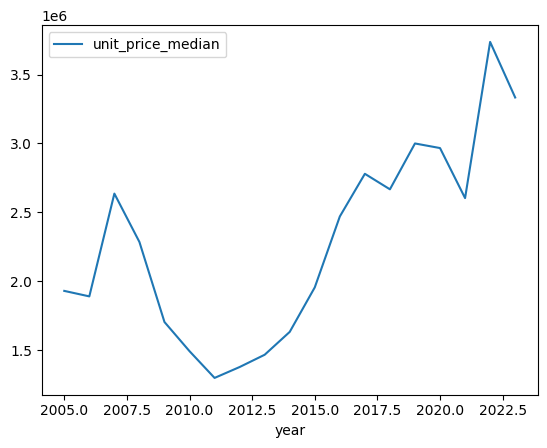

In [46]:
# median
df = derived_dfs["building"]
df = df[df["area_code"] == test_area]
df.plot(x="year", y="unit_price_median")

<Axes: xlabel='year'>

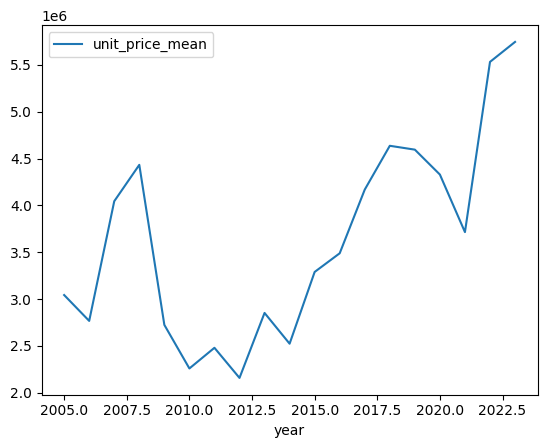

In [48]:
# mean
df = derived_dfs["building"]
df = df[df["area_code"] == test_area]
df.plot(x="year", y="unit_price_mean")

<Axes: xlabel='year'>

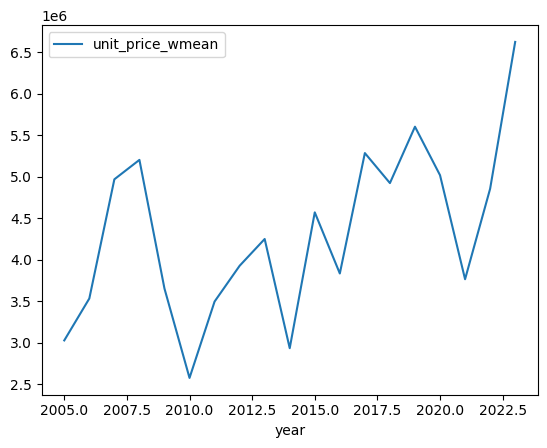

In [49]:
# weighted mean - this makes the most sense. Prices wouldn't be on the decline before the financial crisis
df = derived_dfs["building"]
df = df[df["area_code"] == test_area]
df.plot(x="year", y="unit_price_wmean")